Specify methods

In [114]:
import numpy as np
quantile_type = "summer_q0.95"
run_index = 0

folder_name_maybritt = 'full'
folder_name_benchmarks = "full"
method_list = ['corrdiff_fixed-seeds', "maybritt_nicolai_zeros-constant_dec-1e-3_onehot", "maybritt_nicolai_zeros-constant_dec-1e-3_onehot_temporal"]#, 'corrdiff']
benchmark_indices = list(range(0, 1))
maybritt_indices = list(range(1, 3))

methods = method_list
methods_ws = method_list
method_name_dict = {
        "maybritt_nicolai_zeros-constant_dec-1e-3_onehot": 'EnScale',
        "maybritt_nicolai_zeros-constant_dec-1e-3_onehot_temporal": 'EnScale-t',
        "nn_det_per_variable": "NN-det",
        "gan": "GAN",
        "analogues": "Analogues",
        "idr": "EasyUQ",
        "corrdiff": "CorrDiff-s",
        "corrdiff_fixed-seeds": "CorrDiff"
    }
enscale_method = "maybritt_nicolai_zeros-constant_dec-1e-3_onehot"
methods_short = method_name_dict
version_name = "vnewlayers2_reduced"

In [115]:
from eval_metrics_funs import *

In [116]:
import h5py
import properscoring as ps
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import os
from scipy.stats import rankdata
import pandas as pd

In [117]:
from eval_metrics_funs import *
from utils import *
from eval_funs import *

In [118]:
gcm_list, rcm_list, gcm_dict, rcm_dict = get_rcm_gcm_combinations("/r/scratch/groups/nm/downscaling/cordex-ALPS-allyear")

In [119]:
tuples = list(zip(gcm_list, rcm_list))
print(tuples)

[('CNRM-CM5', 'ALADIN63'), ('MPI-ESM-LR', 'ALADIN63'), ('CNRM-CM5', 'CCLM4-8-17'), ('MIROC5', 'CCLM4-8-17'), ('MPI-ESM-LR', 'CCLM4-8-17'), ('MIROC5', 'REMO2015'), ('CNRM-CM5', 'RegCM4-6'), ('MPI-ESM-LR', 'RegCM4-6')]


In [120]:
for i, (gcm, rcm) in enumerate(tuples):
    print(i, gcm, rcm)

0 CNRM-CM5 ALADIN63
1 MPI-ESM-LR ALADIN63
2 CNRM-CM5 CCLM4-8-17
3 MIROC5 CCLM4-8-17
4 MPI-ESM-LR CCLM4-8-17
5 MIROC5 REMO2015
6 CNRM-CM5 RegCM4-6
7 MPI-ESM-LR RegCM4-6


In [121]:
variables = ["tas", "pr", "sfcWind", "rsds"]

In [122]:
gcm = gcm_list[run_index]
rcm = rcm_list[run_index]
#true_data, gen_data = load_data(gcm, rcm, variables, mode="test_interpolation", run_ids=["maybritt_3step_dense-conv_v3", "maybritt_3step_dense-conv_temporal_v2"], load_diffusion=True, load_gan=True)

In [123]:
plt.rcParams.update({'axes.titlesize': 'small'})

In [124]:
from run_evals_script_metrics_per_gridpoint import *

In [125]:
def create_dict_from_arrays(methods, gcm = "CNRM-CM5", rcm = "ALADIN63",
                            var = "tas", folder = "crps_results", file_suffix = "crps", subfolder = ""):
    results = {}
    for method in methods:
        if subfolder != "":
            folder_full = f"{subfolder}/{folder}"
        results[method] = np.load(f"output_evals_per_loc/{folder_full}/{gcm}_{rcm}_{var}_{method}_{file_suffix}.npy")
    return results

# Marginal quantiles per location

Quantiles with model uncertainty plot

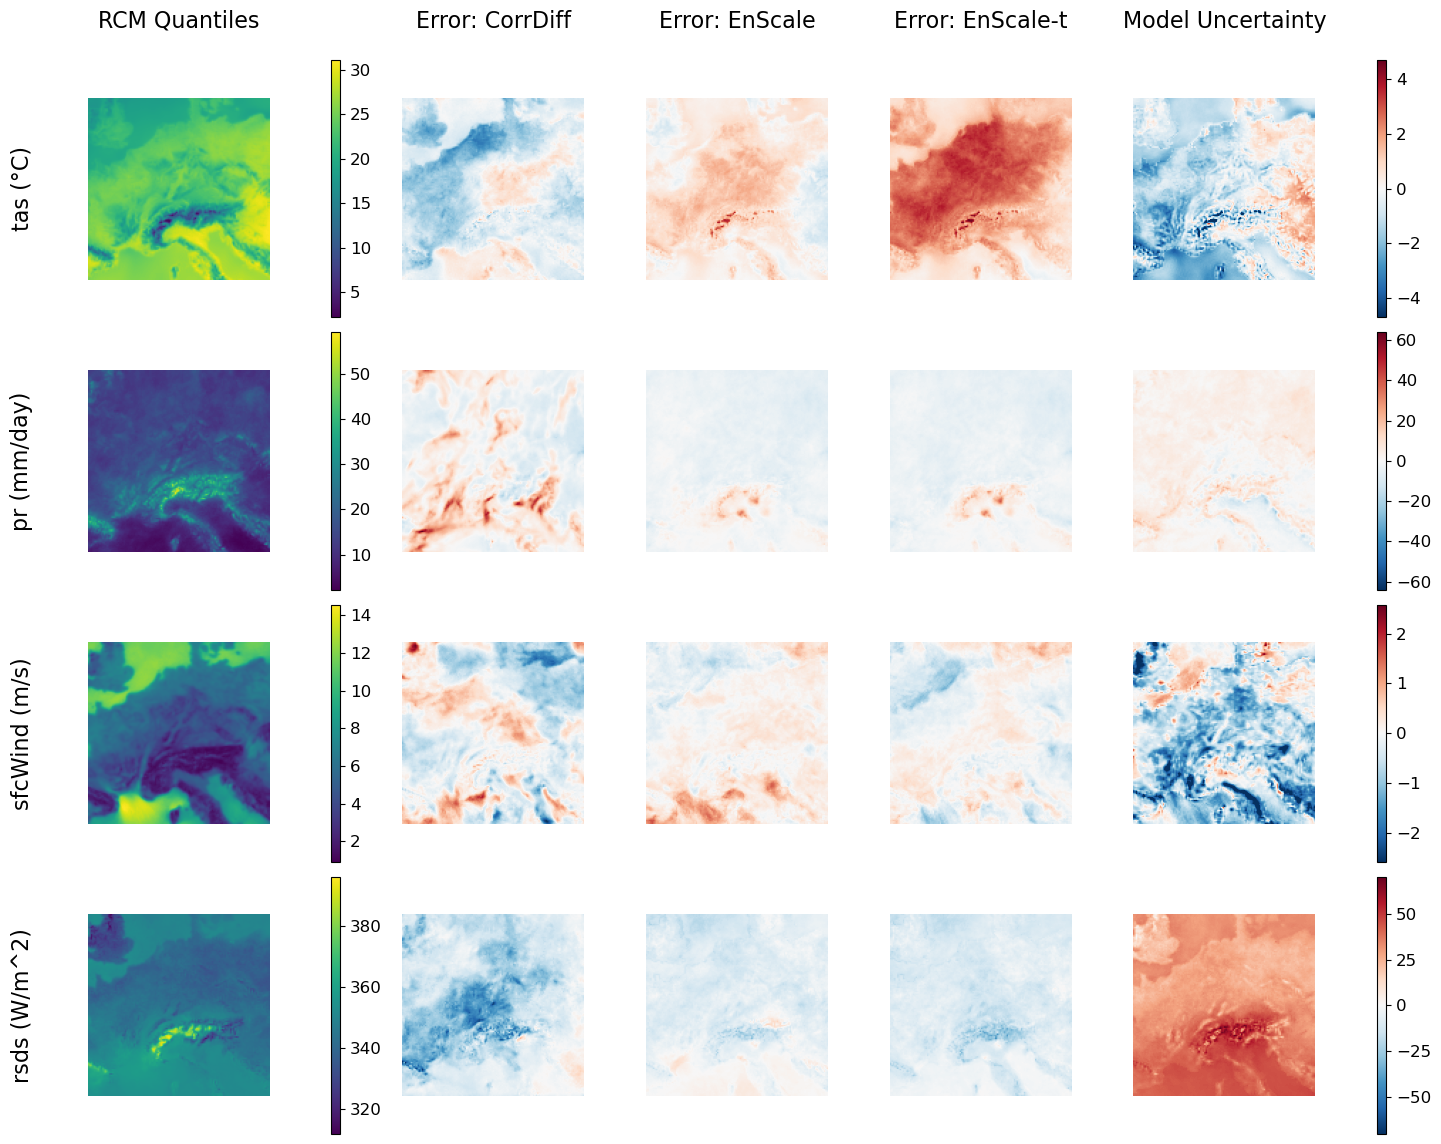

In [126]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(3 * (len(methods_ws) + 2), 3 * len(variables)))
gs = gridspec.GridSpec(len(variables), len(methods_ws) + 4, width_ratios=[1, 0.05] + [1]*len(methods_ws) + [1, 0.05])

mode = quantile_type
units_dict = {
    "tas": "°C", 
    "pr": "mm/day", 
    "sfcWind": "m/s", 
    "rsds": "W/m^2"
}

for i, var in enumerate(variables):
    # output_evals_per_loc/maybritt/interpolation/full/quantile_results
    # and: output_evals_per_loc/benchmarks/interpolation/full/quantile_results

    quantile_results = create_dict_from_arrays([methods[i] for i in benchmark_indices], 
                                               gcm = gcm, rcm = rcm, var = var, folder = "quantile_results", file_suffix = mode,
                                                subfolder=f"benchmarks/interpolation/{folder_name_benchmarks}")
    quantile_results2 = create_dict_from_arrays([methods[i] for i in maybritt_indices], 
                                                gcm = gcm, rcm = rcm, var = var, folder = "quantile_results", file_suffix = mode,
                                                subfolder=f"maybritt/interpolation/{folder_name_maybritt}")
    quantile_results.update(quantile_results2)  # Add maybritt results
    quantile_true = np.load(f"output_evals_per_loc/benchmarks/interpolation/{folder_name_benchmarks}/quantile_results/{gcm}_{rcm}_{var}_true_{mode}.npy")
    rcm2 = rcm_list[2]
    gcm2 = gcm_list[2]
    quantile_true_model2 =  np.load(f"output_evals_per_loc/benchmarks/interpolation/{folder_name_benchmarks}/quantile_results/{gcm2}_{rcm2}_{var}_true_{mode}.npy")

    # === LEFT COLUMN: True quantiles
    ax_true = fig.add_subplot(gs[i, 0])
    vmin = quantile_true.min()
    vmax = quantile_true.max()
    im_true = ax_true.imshow(quantile_true, cmap="viridis", vmin=vmin, vmax=vmax)
    ax_true.axis("off")
    
    # Row label (variables)
    ax_true.text(-0.3, 0.5, f"{var} ({units_dict[var]})", va='center', ha='right', fontsize=16, transform=ax_true.transAxes, rotation=90)

    # Colorbar for quantiles
    cax = fig.add_subplot(gs[i, 1])
    fig.colorbar(im_true, cax=cax)

    # === MIDDLE COLUMNS: Errors per method
    vmin = min((quantile_results[method] - quantile_true).min() for method in methods_ws)
    vmax = max((quantile_results[method] - quantile_true).max() for method in methods_ws)
    vmax = max(abs(vmin), abs(vmax))
    vmin = -vmax

    for j, method in enumerate(methods_ws):
        ax = fig.add_subplot(gs[i, 2 + j])
        im = ax.imshow(quantile_results[method] - quantile_true, vmin=vmin, vmax=vmax, cmap="RdBu_r")
        ax.axis("off")

    # === MODEL DIFFERENCE
    ax = fig.add_subplot(gs[i, 2 + len(methods_ws)])
    im = ax.imshow(quantile_true - quantile_true_model2, vmin=vmin, vmax=vmax, cmap="RdBu_r")
    ax.axis("off")
    
    # Right colorbar
    cax2 = fig.add_subplot(gs[i, 3 + len(methods_ws)])
    fig.colorbar(im, cax=cax2)

    cax.tick_params(labelsize=12)   # Left colorbar (RCM quantiles)
    cax2.tick_params(labelsize=12)  # Right colorbar (errors)

# === COLUMN HEADERS

plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])  # Leave space for headers

# Calculate center x-position of each column in figure coordinates
col_pos = []
for col in range(gs.ncols):
    # Get the bbox (bounding box) of the subplot grid cell
    cell = fig.add_subplot(gs[0, col])  # Just grab one row
    bbox = cell.get_position()
    center = (bbox.x0 + bbox.x1) / 2
    col_pos.append(center)
    plt.delaxes(cell)  # Delete the temp subplot to avoid extra axes
    
fig.text(col_pos[0], 0.96, "RCM Quantiles", va='bottom', ha='center', fontsize=16, rotation=0)
for j, method in enumerate(methods_ws):
    fig.text(col_pos[2 + j], 0.96, f"Error: {methods_short[method]}", va='bottom', ha='center', fontsize=16, rotation=0)

fig.text(col_pos[2 + len(methods_ws)], 0.96, f"Model Uncertainty", va='bottom', ha='center', fontsize=16, rotation=0)
plt.savefig(f"figures/quantiles_error_{gcm}_{rcm}_{quantile_type}_with-model-unc_{version_name}.png")
plt.show()


# Variable-correlations per location

Explanation: 
- Pick a pair of variables and a location
- for both variables, calculate correlations of the time series
- plot over space

Correlations with model uncertainty

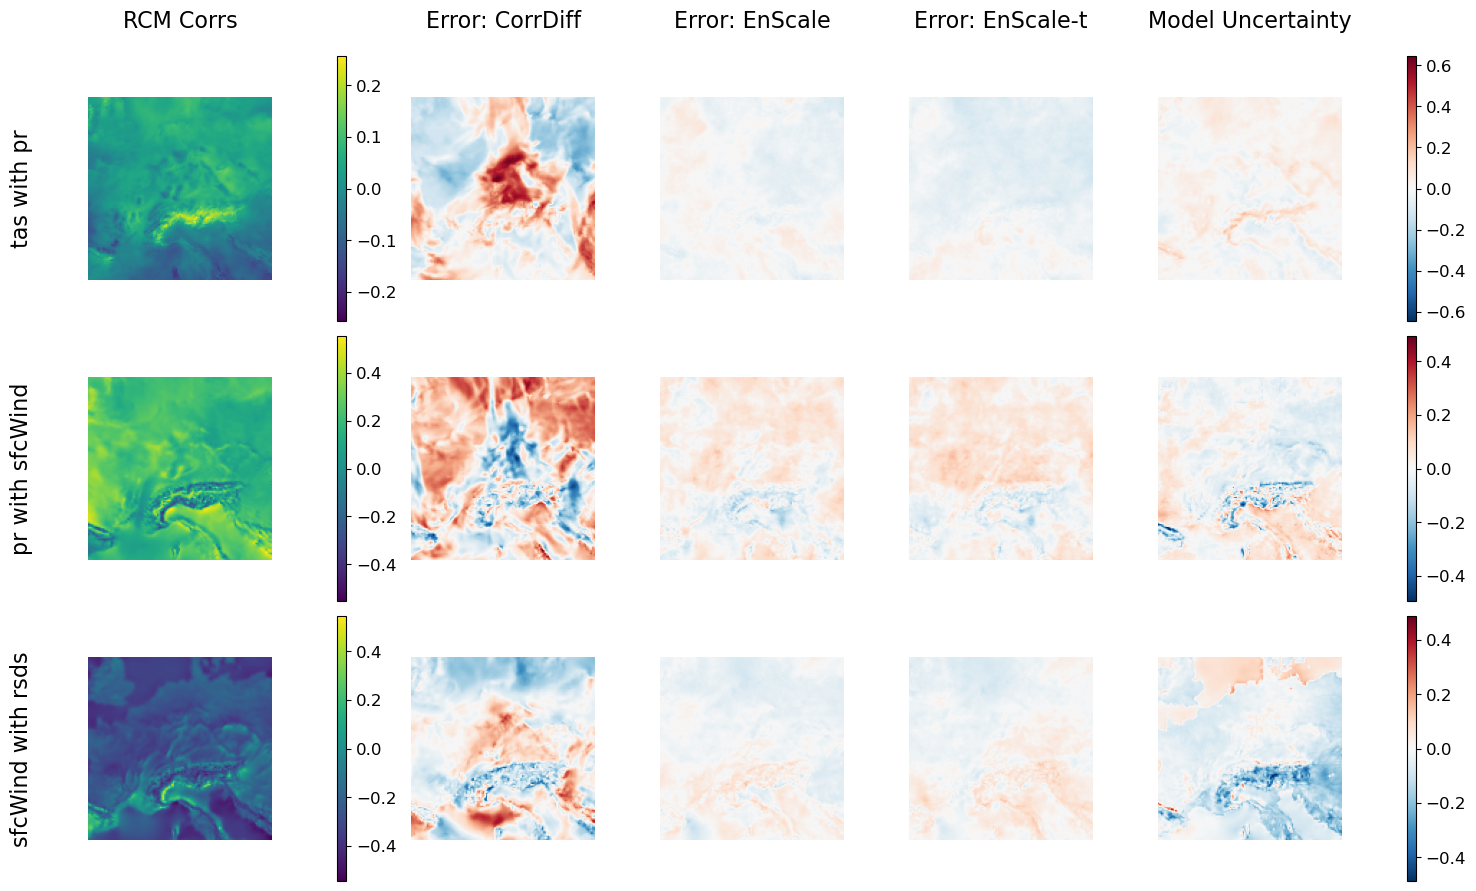

In [128]:
import matplotlib.gridspec as gridspec

variable_pairs = [('tas', 'pr'), ('pr', 'sfcWind'), ('sfcWind', 'rsds')]
fig = plt.figure(figsize=(3 * (len(methods) + 2), 3 * len(variable_pairs)))
gs = gridspec.GridSpec(len(variable_pairs), len(methods) + 4, 
                       width_ratios=[1, 0.05] + [1]*len(methods) + [1, 0.05])

# Plot each row (i.e. variable pair)
for i, (var1, var2) in enumerate(variable_pairs):
    # Load or compute correlations
    corr_results = create_dict_from_arrays([methods[i] for i in benchmark_indices],
                                           gcm=gcm, rcm=rcm, var=f"{var1}_{var2}", 
                                            folder="correlation_results", file_suffix="corr"
                                            , subfolder=f"benchmarks/interpolation/{folder_name_benchmarks}")
    corr_results2 = create_dict_from_arrays([methods[i] for i in maybritt_indices], gcm=gcm, rcm=rcm, var=f"{var1}_{var2}", 
                                            folder="correlation_results", file_suffix="corr"
                                            , subfolder=f"maybritt/interpolation/{folder_name_maybritt}")
    corr_results.update(corr_results2)  # Add maybritt results
    correlation_true = np.load(f"output_evals_per_loc/benchmarks/interpolation/{folder_name_benchmarks}/correlation_results/{gcm}_{rcm}_{var1}_{var2}_true_corr.npy")
    
    rcm2 = rcm_list[2]
    gcm2 = gcm_list[2]
    correlation_true_model2 = np.load(f"output_evals_per_loc/benchmarks/interpolation/{folder_name_benchmarks}/correlation_results/{gcm2}_{rcm2}_{var1}_{var2}_true_corr.npy")

    # True correlation panel
    ax_true = fig.add_subplot(gs[i, 0])
    vmin = min(correlation_true.min(), -correlation_true.max())
    vmax = max(correlation_true.max(), -correlation_true.min())
    im_true = ax_true.imshow(correlation_true, cmap="viridis", vmin=vmin, vmax=vmax)
    ax_true.axis("off")
    
    # Row label (variables)
    ax_true.text(-0.3, 0.5, var1 + " with " + var2, va='center', ha='right', fontsize=16, transform=ax_true.transAxes, rotation=90)

    cax = fig.add_subplot(gs[i, 1])
    fig.colorbar(im_true, cax=cax)
    cax.tick_params(labelsize=12)

    # Errors
    vmin = min((corr_results[method] - correlation_true).min() for method in methods_ws)
    vmax = max((corr_results[method] - correlation_true).max() for method in methods_ws)
    vmax = max(abs(vmin), abs(vmax))
    vmin = -vmax

    for j, method in enumerate(methods_ws):
        ax = fig.add_subplot(gs[i, 2 + j])
        im = ax.imshow(corr_results[method] - correlation_true, vmin=vmin, vmax=vmax, cmap="RdBu_r")
        ax.axis("off")

    # Model-to-model diff
    ax = fig.add_subplot(gs[i, 2 + len(methods_ws)])
    im = ax.imshow(correlation_true - correlation_true_model2, vmin=vmin, vmax=vmax, cmap="RdBu_r")
    ax.axis("off")

    cax2 = fig.add_subplot(gs[i, 3 + len(methods_ws)])
    fig.colorbar(im, cax=cax2)
    cax2.tick_params(labelsize=12)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

# === Add aligned column headers ===
# Calculate center x-position of each column in figure coordinates
col_pos = []
for col in range(gs.ncols):
    # Get the bbox (bounding box) of the subplot grid cell
    cell = fig.add_subplot(gs[0, col])  # Just grab one row
    bbox = cell.get_position()
    center = (bbox.x0 + bbox.x1) / 2
    col_pos.append(center)
    plt.delaxes(cell)  # Delete the temp subplot to avoid extra axes

# Set column headers
fig.text(col_pos[0], 0.965, "RCM Corrs", ha='center', fontsize=16)
for j, method in enumerate(methods_ws):
    fig.text(col_pos[2 + j], 0.965, f"Error: {methods_short[method]}", ha='center', fontsize=16)
fig.text(col_pos[2 + len(methods_ws)], 0.965, "Model Uncertainty", ha='center', fontsize=16)

# Save and show
plt.savefig(f"figures/correlation_error_{gcm}_{rcm}_with-model-unc_{version_name}.png", bbox_inches='tight')
plt.show()
